## Описание данных
* timestamp – дата и время (точность до часа)
* cnt – количество аренд велосипедов за этот час
* t1 – температура, в С
* t2 – температура "ощущается как", в С 
* hum – влажность (%)
* wind_speed – скорость ветра, км/ч
* weather_code – погодные условия:
    - 1 – ясно (SKC)
    - 2 – преимущественно ясно / встречаются отдельные облака (SCT)
    - 3 – облачно / значительные облака (BKN)
    - 4 – пасмурно (OVC)
    - 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    - 10 – дождь с грозой
    - 26 – снегопад 
    - 94 – ледяной туман (да, такое бывает!)
* isholiday – является ли день праздником (1 – праздник, 0 – нет)
* isweekend –  является ли день выходным (1 – выходной, 0 – нет)
* season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

### Задание 1

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Есть ли в данных пропущенные значения?

In [1]:
import pandas as pd
import numpy as np

In [2]:
london = pd.read_csv('london.csv')
london.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [3]:
london = pd.read_csv('london.csv', parse_dates=['timestamp'])
london['timestamp'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17414 entries, 0 to 17413
Series name: timestamp
Non-Null Count  Dtype         
--------------  -----         
17414 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 136.2 KB


In [4]:
london.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Ответ: Нет

### Задание 2

Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

* по оси x – дата (timestamp)
* по оси y – число поездок (cnt)

*sns.lineplot*

Выберите верные утверждения:

* В выходные поездок точно меньше, чем в будние дни
* Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды
* Случались только аномальные скачки вверх, вниз ничего не падало


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('Solarize_Light2')
sns.set(font_scale=2,\
        style="whitegrid",\
        rc={'figure.figsize':(16,8)}
        )

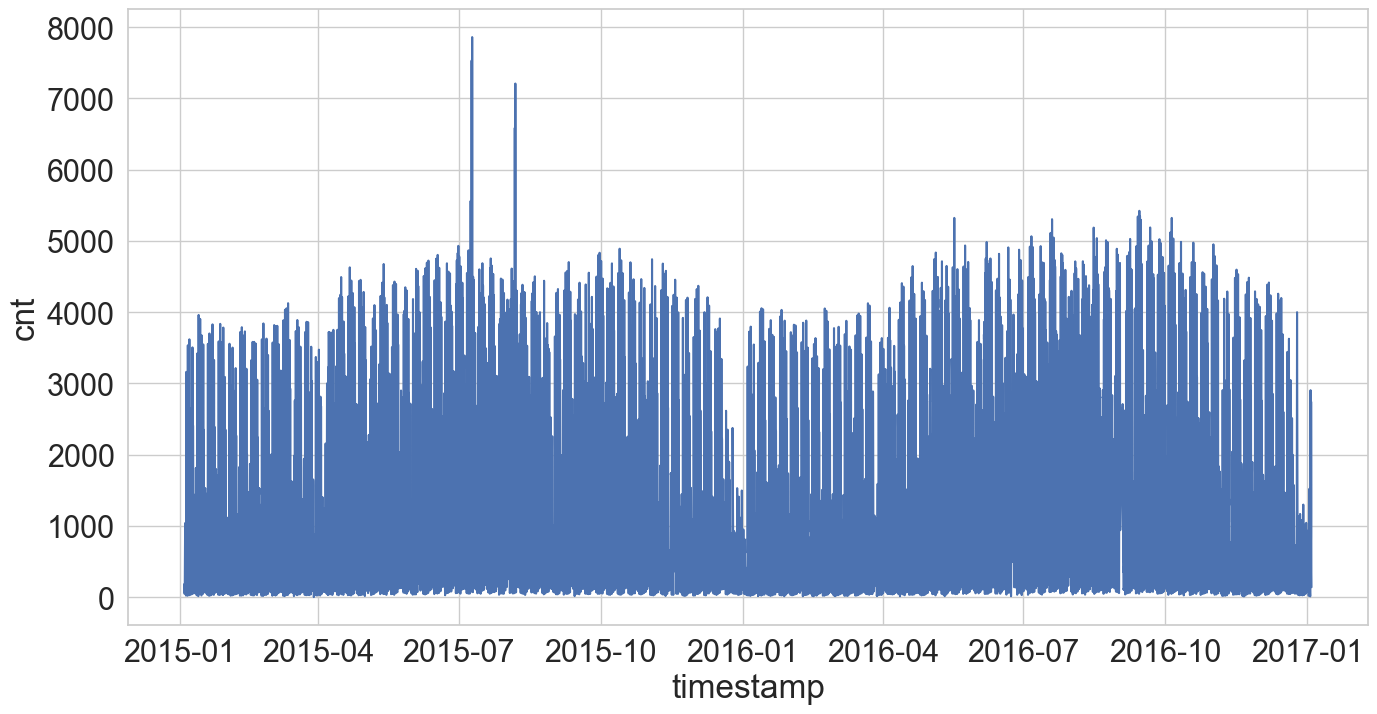

In [6]:
sns.lineplot(data=london, x=london['timestamp'], y=london['cnt']);

Ответ:
* Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

### Задание 3

Отлично! Предположим, что данные действительно нужно немного преобразовать. В этом нам поможет resample, с которым вы могли столкнуться в дополнительных темах pandas. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. Например, посчитать сумму показателя по дням, имея данные по часам, можно следующим образом:

```python
data.resample(rule='D').column_name.sum() #способ 1
data.resample(rule='D').agg({'column_name':'sum'}) #способ 2
```

Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?

Выберите верные утверждения:
* Встречаются только резкие скачки вверх
* Максимальное число аренд за день – более 1 000 000
* Зимой число аренд меньше, чем летом
* Встречаются как очень резкие скачки числа аренд, так и падения
* Максимальное число аренд за день составляет более 70 000
* Число аренд зимой и летом никак не различается
* Максимальное число аренд за день не превышало 8 000


In [7]:
london.sort_values(by='timestamp', inplace=True)
london.set_index('timestamp', drop=False, inplace=True)

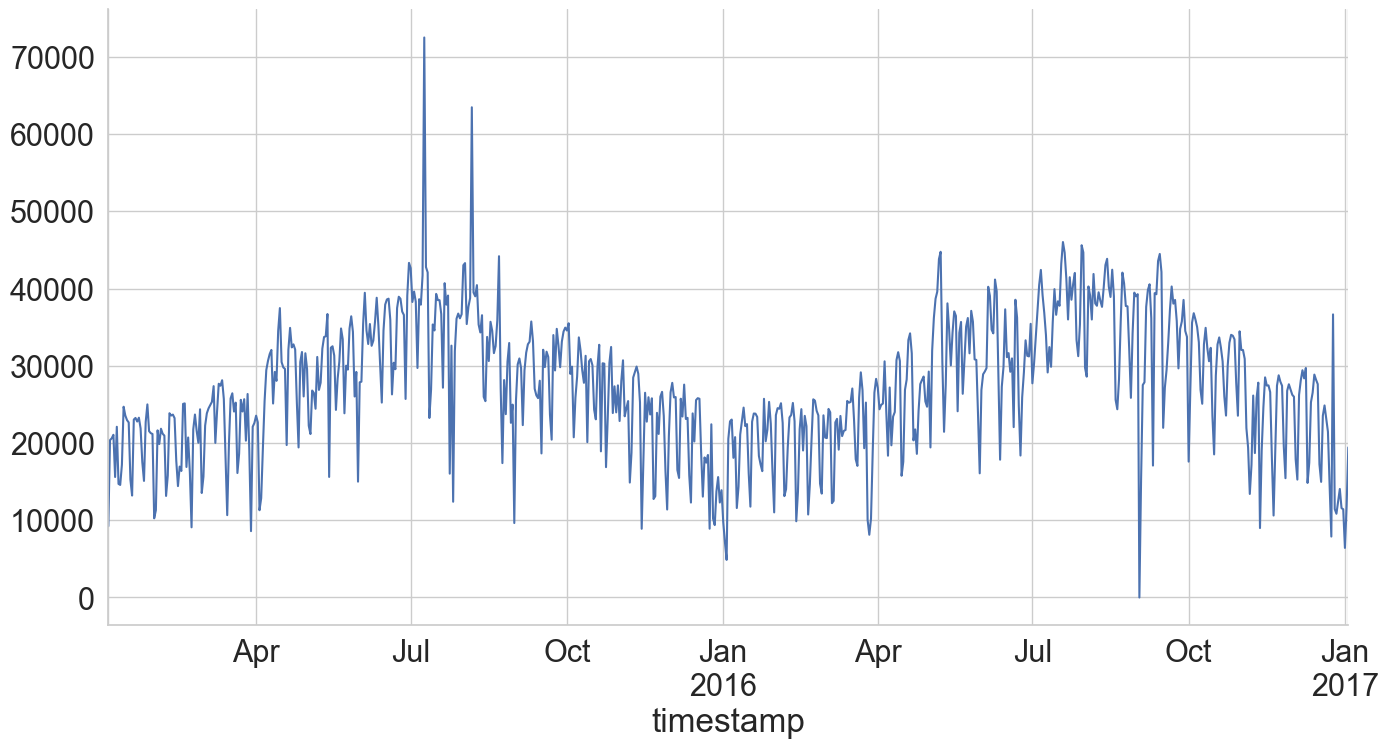

In [8]:
london.resample('D')['cnt'].sum().plot()
sns.despine()

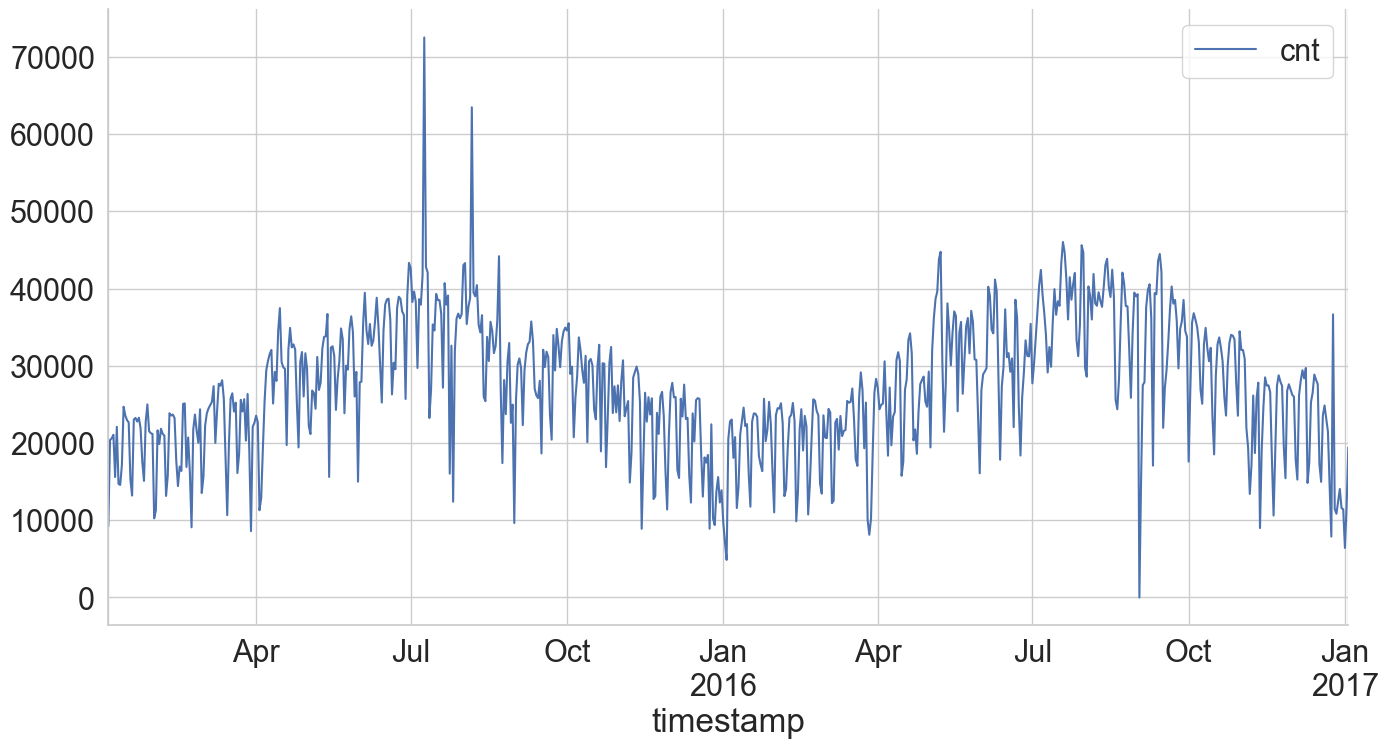

In [9]:
london.resample('D').agg({'cnt':'sum'}).plot()
sns.despine()

Ответ:
* Зимой число аренд меньше, чем летом
* Встречаются как очень резкие скачки числа аренд, так и падения
* Максимальное число аренд за день составляет более 70 000

### Задание 4

Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день.

Для этого разделим дальнейшие действия на несколько этапов:

* сначала посчитаем скользящее среднее, чтобы сгладить ряд
* далее – разницу между наблюдаемыми и сглаженными значениями
* определим верхние и нижние границы 99% доверительного интервала 
* найдем причины аномалий!

На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [10]:
by_day = london.resample('D')['cnt'].sum().reset_index()
by_day.head(3)

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613


In [11]:
by_day_roll = london.resample('D')['cnt'].sum().rolling(window=3).mean().reset_index()
by_day_roll.head(3)

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667


In [12]:
by_day_roll.query("timestamp == '2015-07-09'")

,timestamp,cnt
186,2015-07-09,50705.0


Ответ: 50705

### Задание 5

Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями. Далее – примените функцию для подсчета стандартного отклонения. Например:
```
c = a - b
std = np.std(c)
```
В качестве ответа введите полученное стандартное отклонение, округленное до 2 знаков после точки.

In [13]:
np.round(np.std(by_day['cnt'] - by_day_roll['cnt']), 2)

4558.59

Ответ: 4558.59

### Задание 6

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

* upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
* lower_bound – нижняя граница; вычитаем 2.576∗std

Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

*В качестве std нужно брать стандартное отклонение без округления*

*Вам может понадобиться убрать даты из индекса - иногда из-за этого колонки могут не присваиваться в датафрейм. Вам пригодится .reset_index()*

In [14]:
std = np.std(by_day['cnt'] - by_day_roll['cnt'])
upper_bound = by_day_roll['cnt'] + (2.576 * std)
lower_bound = by_day_roll['cnt'] - (2.576 * std)

In [15]:
by_day['upper_bound'] = upper_bound
by_day['lower_bound'] = lower_bound
by_day.head(3)

,timestamp,cnt,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.585854,4996.747479


In [16]:
np.round(upper_bound.iloc[-1], 2)

24302.92

Ответ: 24302.92

### Задание 7

И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим? 

*Укажите дату в формате 2020-12-31*

In [17]:
by_day[by_day['cnt'] > by_day['upper_bound']]

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.919188,38962.080812
214,2015-08-06,63468,58370.252521,34884.414146
609,2016-09-04,27512,26001.919188,2516.080812
721,2016-12-25,36653,31393.585854,7907.747479


In [18]:
by_day[by_day['cnt'] > by_day['upper_bound']]['timestamp'].head(1)

186   2015-07-09
Name: timestamp, dtype: datetime64[ns]

Ответ: 2015-07-09

### Задание 8

Подумайте, в чем может быть причина столь высокого числа аренд в этот день. Для этого можете исследовать уже имеющиеся переменные в датасете, проверить наличие ошибок в данных (повторяющихся строк), а также использовать поиск Google. 

В качестве ответа выберите наиболее вероятную причину столь резкого скачка:

* Забастовки в метро
* Ветер
* Погода
* Ошибка при сборе данных
* Выборы

Ответ:
* Забастовки в метро

|09.07.2015|
|:-:|
|**Жизнь без метро: давка в автобусах и очереди на остановках в Лондоне**
*Лондонское метро закрылось из-за забастовки работников подземки*|

### Задание 9

Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

* Забастовки
* Ветер
* Погода
* Пробки
* Ошибка при сборе данных
* Выборы

In [19]:
by_day[by_day['cnt'] < by_day['lower_bound']]

,timestamp,cnt,upper_bound,lower_bound
130,2015-05-14,15609,40452.252521,16966.414146
189,2015-07-12,23240,47779.585854,24293.747479
201,2015-07-24,16034,42756.585854,19270.747479
232,2015-08-24,17400,41272.252521,17786.414146
314,2015-11-14,8898,32780.252521,9294.414146
607,2016-09-02,0,37829.252521,14343.414146
615,2016-09-10,17080,43004.919188,19519.080812
621,2016-09-16,21967,47936.252521,24450.414146
678,2016-11-12,8990,32620.919188,9135.080812


Ответ:
* Ошибка при сборе данных